<a href="https://colab.research.google.com/github/fyng/PassplayNET/blob/main/NFLDataBowl2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Kaggle Challenge

Refer to https://www.kaggle.com/general/74235

1. Create and upload kaggle.json

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# # check if connection is working
# ! kaggle datasets list

In [ ]:
! kaggle competitions download -c nfl-big-data-bowl-2023
! unzip /content/nfl-big-data-bowl-2023.zip

nfl-big-data-bowl-2023.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/nfl-big-data-bowl-2023.zip
  inflating: games.csv               
  inflating: pffScoutingData.csv     
  inflating: players.csv             
  inflating: plays.csv               
  inflating: week1.csv               
  inflating: week2.csv               
  inflating: week3.csv               
  inflating: week4.csv               
  inflating: week5.csv               
  inflating: week6.csv               
  inflating: week7.csv               
  inflating: week8.csv               


How train is made?

Every row is a unique play in a unique game

Every row contains relevant data of every player. 
* each variable spans 1 second, spaced with every 1/10 of a second (only 2 NAs)
* every record is the same length

Action_time based on different events (Mason and Tad)

Pass yards (Feiyang & Eric)

# Explore Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Play Data

Play data
* `gameId`: Game identifier, unique (numeric)
* `playId`: Play identifier, not unique across games (numeric)
* `playDescription`: Description of play (text)
* `quarter`: Game quarter (numeric)
* `down`: Down (numeric)
* `yardsToGo`: Distance needed for a first down (numeric)
* `possessionTeam`: Team abbr of team on offense with possession of ball (text)
* `defensiveTeam`: Team abbr of team on defense (text)
* `yardlineSide`: 3-letter team code corresponding to line-of-scrimmage (text)
* `yardlineNumber`: Yard line at line-of-scrimmage (numeric)
* `gameClock`: Time on clock of play (MM:SS)
* `preSnapHomeScore`: Home score prior to the play (numeric)
* `preSnapVisitorScore`: Visiting team score prior to the play (numeric)
* `passResult`: Dropback outcome of the play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, text)
* `penaltyYards`: yards gained by offense by penalty (numeric)
* `prePenaltyPlayResult`: Net yards gained by the offense, before penalty yardage (numeric)
* `playResult`: Net yards gained by the offense, including penalty yardage (numeric)
* `foulName[i]`: Name of the i-th penalty committed during the play. i ranges between 1 and 3 (text)
* `foulNFLId[i]`: nflId of the player who comitted the i-th penalty during the play. i ranges between 1 and 3 (numeric)
* `absoluteYardlineNumber`: Distance from end zone for possession team (numeric)
* `offenseFormation`: Formation used by possession team (text)
* `personnelO`: Personnel used by offensive team (text)
* `defendersInTheBox`: Number of defenders in close proximity to line-of-scrimmage (numeric)
* `personnelD`: Personnel used by defensive team (text)
* `dropbackType`: Dropback categorization of quarterback (text)
* `pff_playAction`: indicator for whether offense executes play action fake on the play. Variable provided by PFF (binary)
* `pff_passCoverage`: Coverage scheme of defense. Variable provided by PFF (text)
* `Bracket`: Recorded in the field and up to the 12 yard line in the red zone – when two offensive players have an in and out bracket by two defenders
* `Goal Line`: Calls where a Goal Line defense is used.
* `Red Zone`: Calls that are typically specific to the Red Zone and do not occur in the field often
* `Prevent`: Special end of half or end of game situations where a Prevent defense is utilized
* `Miscellaneous`: Coverage concepts that we feel do not comfortably fit into any of our coverage categories
* `pff_passCoverageType`: Whether defense's coverage type was man, zone or other. Variable provided by PFF (text)



In [ ]:
pl = pd.read_csv("/content/plays.csv")

In [ ]:
play = pl[['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'playResult']]

print(play.shape)
play.head()

(8557, 6)


,gameId,playId,quarter,down,yardsToGo,playResult
0,2021090900,97,1,3,2,0
1,2021090900,137,1,1,10,28
2,2021090900,187,1,2,6,5
3,2021090900,282,1,1,10,0
4,2021090900,349,1,3,15,0


### Tracking Data

Tracking data
Files week[week].csv contains player tracking data from week [week].

* `gameId`: Game identifier, unique (numeric)
* `playId`: Play identifier, not unique across games (numeric)
* `nflId`: Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
* `frameId`: Frame identifier for each play, starting at 1 (numeric)
* `time`: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
* `jerseyNumber`: Jersey number of player (numeric)
* `club`: Team abbrevation of corresponding player (text)
* `playDirection`: Direction that the offense is moving (left or right)
* `x`: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
* `y`: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
* `s`: Speed in yards/second (numeric)
* `a`: Acceleration in yards/second^2 (numeric)
* `dis`: Distance traveled from prior time point, in yards (numeric)
* `o`: Player orientation (deg), 0 - 360 degrees (numeric)
* `dir`: Angle of player motion (deg), 0 - 360 degrees (numeric)
* `event`: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

In [ ]:
# Position data of all players for the first 1 second of the game, at 0.1 second time resolution
# Position data: x-y position, speed, acceleration, distance traveled, orientation, direction

field = pd.read_csv("https://raw.githubusercontent.com/fyng/PassplayNET/main/training_data.csv")
field = field.drop(['action_time', 'event'], axis = 1)

print(field.shape)
field.head()

(8071, 387)


,gameId,playId,x_0_C,x_0_LT,x_0_LG,x_0_RG,x_0_RT,x_0.1_C,x_0.1_LT,x_0.1_LG,...,dir_0.9_C,dir_0.9_LT,dir_0.9_LG,dir_0.9_RG,dir_0.9_RT,dir_1_C,dir_1_LT,dir_1_LG,dir_1_RG,dir_1_RT
0,2021090900,97,42.10,41.38,41.93,41.41,41.11,42.03,41.28,41.92,...,285.24,287.77,270.50,257.73,265.30,283.12,284.67,269.06,254.98,271.06
1,2021090900,137,109.22,109.62,109.38,108.74,109.85,109.23,109.62,109.40,...,108.10,78.57,87.15,75.40,52.29,101.57,86.06,87.84,74.85,59.29
2,2021090900,187,77.67,78.27,78.04,77.89,78.27,77.74,78.30,78.10,...,66.90,114.62,58.75,65.39,66.44,67.82,108.23,58.58,67.31,71.08
3,2021090900,282,49.82,50.62,50.41,50.51,50.53,49.89,50.63,50.36,...,129.31,67.66,155.38,178.61,193.86,133.71,65.34,133.87,165.07,189.11
4,2021090900,349,54.93,55.78,55.73,55.72,55.78,55.01,55.81,55.74,...,92.44,99.67,99.29,68.57,71.53,93.19,99.64,95.55,69.08,71.77


### Combined Game State Data

In [ ]:
# Each row is a unique combination of playId and gameId

data = pd.merge(field, play, on=['gameId', 'playId'])

# remove NaN and Inf
print(data.shape)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
print(data.shape)

data.head()

(8071, 391)
(8069, 391)


,gameId,playId,x_0_C,x_0_LT,x_0_LG,x_0_RG,x_0_RT,x_0.1_C,x_0.1_LT,x_0.1_LG,...,dir_0.9_RT,dir_1_C,dir_1_LT,dir_1_LG,dir_1_RG,dir_1_RT,quarter,down,yardsToGo,playResult
0,2021090900,97,42.10,41.38,41.93,41.41,41.11,42.03,41.28,41.92,...,265.30,283.12,284.67,269.06,254.98,271.06,1,3,2,0
1,2021090900,137,109.22,109.62,109.38,108.74,109.85,109.23,109.62,109.40,...,52.29,101.57,86.06,87.84,74.85,59.29,1,1,10,28
2,2021090900,187,77.67,78.27,78.04,77.89,78.27,77.74,78.30,78.10,...,66.44,67.82,108.23,58.58,67.31,71.08,1,2,6,5
3,2021090900,282,49.82,50.62,50.41,50.51,50.53,49.89,50.63,50.36,...,193.86,133.71,65.34,133.87,165.07,189.11,1,1,10,0
4,2021090900,349,54.93,55.78,55.73,55.72,55.78,55.01,55.81,55.74,...,71.53,93.19,99.64,95.55,69.08,71.77,1,3,15,0


### Understanding the Data

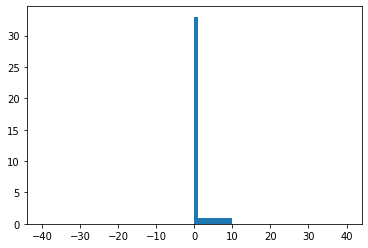

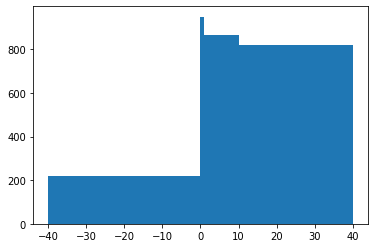

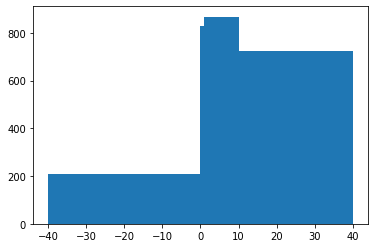

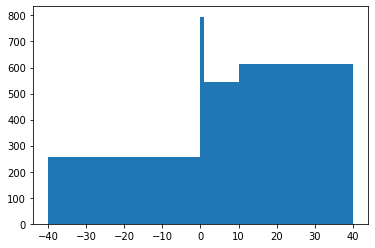

In [ ]:
plt.hist(data[data['down'] == 0]['playResult'], bins=[-40, 0, 1, 10, 40])
plt.show()

plt.hist(data[data['down'] == 1]['playResult'], bins=[-40, 0, 1, 10, 40])
plt.show()

plt.hist(data[data['down'] == 2]['playResult'], bins=[-40, 0, 1, 10, 40])
plt.show()

plt.hist(data[data['down'] == 3]['playResult'], bins=[-40, 0, 1, 10, 40])
plt.show()
# Question for Eric: is it intuitive for most plays to have 0 net yards gained?

# Models

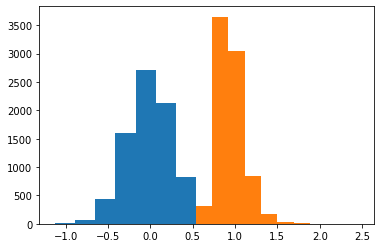

In [ ]:
X = data.loc[:, 'x_0_C':'yardsToGo']
names = X.columns
scalar = preprocessing.StandardScaler()
X = scalar.fit_transform(X)

plt.hist(X.mean(axis = 1))
plt.hist(X.std(axis = 1))

y = data['playResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# try simple linear regression first

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

-0.05799500618530007

That doesn't look too good.. Let's try something more advanced

In [ ]:
# how about a decision tree?
from sklearn import tree
score = []

for i in range(5, 20, 5):
    clf = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth=i, random_state=42)
    clf = clf.fit(X_train, y_train)
    clf_score = clf.score(X_test, y_test)
    score.append(clf_score)

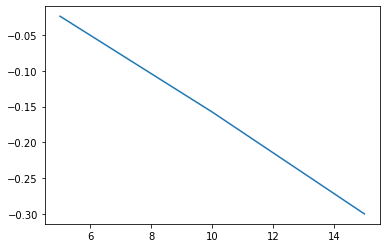

In [ ]:
plt.plot(range(5, 20, 5), score)

Decision tree also does poorly, furthermore deeper trees overfit. Oh-oh..

Text(0, 0.5, 'Principal Component 2')

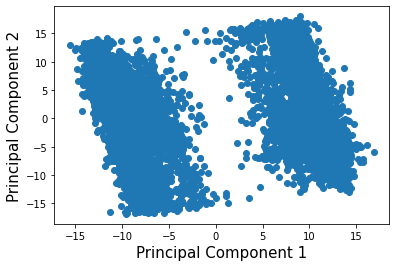

In [ ]:
# Do some PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, y], axis = 1)

plt.scatter(finalDf['pc1'], finalDf['pc2'])
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)

# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# targets = y.unique().tolist()
# colors = ['r', 'g', 'b']
# for target in targets:
#     # rgb = (np.random.rand(), np.random.rand(), np.random.rand())
#     indicesToKeep = finalDf['playResult'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#             #    , c = rgb
#                , s = 50)
# ax.legend(targets)
# ax.grid()


In [ ]:
i = pca.components_[0,:].argmax()
names[i]

'dir_1_C'

In [ ]:
# Random forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

-0.04565543678507833